In [51]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45536 entries, 0 to 45535
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     45536 non-null  object 
 1   description               45536 non-null  object 
 2   summary                   45520 non-null  object 
 3   installs                  45536 non-null  object 
 4   minInstalls               45536 non-null  float64
 5   score                     45536 non-null  float64
 6   ratings                   45536 non-null  float64
 7   reviews                   45536 non-null  float64
 8   histogram                 45536 non-null  object 
 9   price                     45536 non-null  float64
 10  free                      45536 non-null  int64  
 11  currency                  45536 non-null  object 
 12  sale                      45536 non-null  bool   
 13  offersIAP                 45536 non-null  bool   
 14  inAppP

In [53]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','has_video']]

y = df['score']

In [54]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,test_size=.20, random_state=10)

In [55]:
## Define pipeline transformers 

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',sparse='false'))])

In [56]:
numeric_features = X.select_dtypes(include=['float64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [57]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear', LinearRegression())])

In [58]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ratings', 'installs_day'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse='false'))]),
                                                  Index(['genre', 'contentRating'], dtype='object'))])),
                ('linear', LinearRegression())])

In [59]:
y_pred = lr.predict(X_val)

In [60]:
lr.score(X_val,y_val)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.10
MSE of linear regression on val set: 0.45


In [61]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val.columns, lr['linear'].coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.10
free : 0.01
containsAds : -0.02
genre : 0.05
editorsChoice : 0.13
contentRating : 0.10
year : -0.03
top_developer : 0.13
installs_day : 0.36
has_video : 0.09


In [62]:
X_train_cont = X_train[['free','containsAds','editorsChoice','year','top_developer','installs_day','has_video']]
X_val_cont = X_val[['free','containsAds','editorsChoice','year','top_developer','installs_day','has_video']]

In [63]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[['genre','contentRating']])

ohe_x_train = ohe.transform(X_train[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_train_df = pd.DataFrame(ohe_x_train, columns=columns, index=X_train.index)

In [64]:
ohe_v = OneHotEncoder(drop='first', sparse=False)

ohe_v.fit(X_val[['genre','contentRating']])

ohe_x_val = ohe_v.transform(X_val[['genre','contentRating']])

columns_v = ohe_v.get_feature_names(['genre','contentRating'])

ohe_x_val_df = pd.DataFrame(ohe_x_val, columns=columns_v, index=X_val.index)

In [65]:
#Merge cont and cat DFs
combo_train_df = pd.concat([X_train_cont, ohe_x_train_df], axis=1)

combo_val_df =  pd.concat([X_val_cont, ohe_x_val_df], axis=1)

In [66]:
lr = LinearRegression()

lr.fit(combo_train_df, y_train)

y_pred = lr.predict(combo_val_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(combo_val_df, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.13
MSE of linear regression on val set: 0.44


In [67]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df.columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.22
containsAds : 0.10
editorsChoice : 0.20
year : 0.01
top_developer : 0.66
installs_day : 0.00
has_video : 0.09
genre_Adventure : -0.04
genre_Arcade : 0.06
genre_Art & Design : 0.11
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.04
genre_Board : 0.14
genre_Books & Reference : 0.31
genre_Business : 0.17
genre_Card : 0.27
genre_Casino : 0.38
genre_Casual : 0.04
genre_Comics : -0.08
genre_Communication : 0.06
genre_Dating : -0.05
genre_Education : 0.22
genre_Educational : 0.07
genre_Entertainment : -0.04
genre_Events : 0.11
genre_Finance : 0.13
genre_Food & Drink : 0.25
genre_Health & Fitness : 0.25
genre_House & Home : 0.08
genre_Libraries & Demo : -0.09
genre_Lifestyle : 0.12
genre_Maps & Navigation : 0.06
genre_Medical : 0.20
genre_Music : -0.00
genre_Music & Audio : 0.14
genre_News & Magazines : 0.04
genre_Parenting : 0.20
genre_Personalization : 0.24
genre_Photography : -0.02
genre_Productivity : 0.12
genre_Puzzle : 0.21
genre_Racing : 0.01
g

In [68]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(combo_val_df)
check['resid'] = check['pred'] - check['score']

In [69]:
check.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,has_video,score,pred,resid
27648,3318.0,1,0,Health & Fitness,0,Everyone,2019,0,649.350649,0,1.345238,4.103658,2.758420
38747,9436.0,1,0,Tools,0,Everyone,2013,0,185.391175,1,1.343005,3.973291,2.630285
4940,8452.0,1,0,Lifestyle,0,Everyone,2015,0,479.616307,1,1.492308,4.048583,2.556275
41417,14214.0,1,1,News & Magazines,0,Everyone,2014,0,391.083301,1,1.559055,4.061629,2.502574
7507,117.0,1,1,Entertainment,0,Teen,2015,0,500.751127,0,1.440000,3.887922,2.447922
36184,2942.0,1,1,Art & Design,0,Everyone,2017,0,372.300819,0,1.717687,4.060258,2.342571
38016,4775.0,1,1,Tools,0,Everyone,2015,0,470.366886,1,1.851464,4.088092,2.236627
10837,3122.0,1,0,Books & Reference,0,Everyone 10+,2013,0,177.367861,0,1.987180,4.179728,2.192548
39415,2461.0,1,1,Video Players & Editors,0,Everyone,2019,0,656.167979,0,1.699187,3.881213,2.182026
34965,3600.0,1,1,Art & Design,0,Teen,2019,0,1121.076233,0,1.897222,4.065587,2.168365


In [70]:
check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,has_video,score,pred,resid
32366,3290.0,1,1,Tools,0,Everyone,2017,0,780.640125,0,4.063444,4.010056,-0.053388
31209,5590.0,1,1,Educational,0,Teen,2016,0,553.403431,1,4.014210,4.095255,0.081045
40857,13553.0,1,1,Racing,0,Everyone 10+,2013,0,368.459838,1,4.152655,4.074649,-0.078005
16330,50556.0,1,1,Music & Audio,0,Everyone,2013,0,1773.049645,0,4.003363,4.068243,0.064880
2773,12810.0,1,1,Educational,0,Everyone,2018,0,1152.073733,1,4.089300,4.121064,0.031765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10639,6898.0,1,0,Music & Audio,0,Everyone,2015,1,252.780586,0,4.710983,4.629779,-0.081204
16449,9102.0,1,1,Puzzle,0,Everyone,2018,0,1207.729469,1,4.353846,4.255487,-0.098359
43811,3893.0,1,1,Strategy,0,Everyone,2017,0,340.136054,1,4.033333,4.130587,0.097254
24878,5140.0,1,1,Tools,0,Everyone,2017,0,861.326443,0,4.076336,4.010478,-0.065858


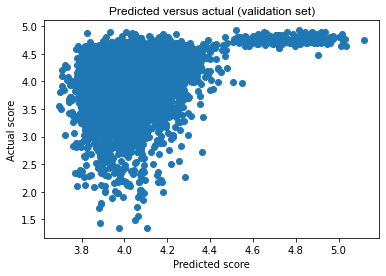

In [71]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

Specifically, way over predicting the lower scoring apps - typically earleir years